# Introduction

Implement YOLO usage as explained in the following articles:
- [Towards Data Science](https://towardsdatascience.com/yolo-object-detection-with-opencv-and-python-21e50ac599e9)
- [OpenCV Tutorial](https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html)

<br>

The model has been trained over the [COCO Dataset](https://cocodataset.org/#home).

In [99]:
# Import Standard Libraries
import cv2
import numpy as np
import os
from urllib.request import urlretrieve
from typing import List, Tuple
from matplotlib import pyplot as plt

In [100]:
# Notebook variables
sample_image_path = './../images/dog_image_1.jpeg'
classes_path = './../files/yolov3_classes.txt'
nn_config_path = './../files/yolov3.cfg'
nn_weights_url = 'https://pjreddie.com/media/files/yolov3.weights'
nn_weights_path = './../files/yolov3.weights'

# Read Data

## Image

In [101]:
# Read the image with OpenCV
image = cv2.imread(sample_image_path)

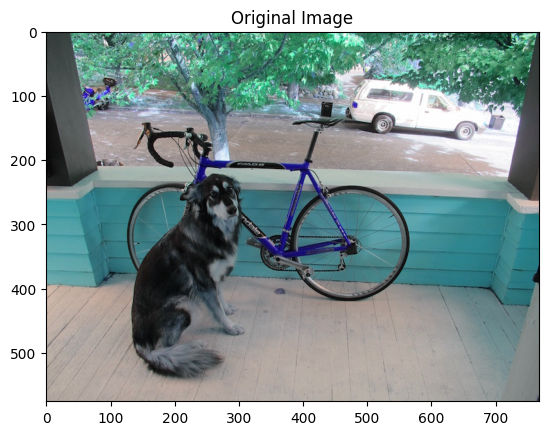

In [102]:
# Show image
plt.imshow(image)
plt.title('Original Image')
plt.show()

In [103]:
# The image is 576 x 768 dimension in pixels
# It has 3 channels, since it is colored (RGB)
image.shape

(576, 768, 3)

In [104]:
# Compute image's width and height
image_width = image.shape[1]
image_height = image.shape[0]

# Define the scale factor for each image's pixel
scale = 1/255.0

 ## Classes

In [105]:
# Open the classes file and extract the list of available classes
with open(classes_path, 'r') as classes_file:
    classes = [line.strip() for line in classes_file.readlines()]

In [106]:
# generate different colors for each class 
class_colors = np.random.uniform(0, 255, size=(len(classes), 3))

## Neural Network

The neural network is divided into two files:
1. **yolov3.weights** - It contains the weights of the single neuron in the Neural Network
2. **yolov3.cfg** - It contains the structure of the Neural Network

In [107]:
# Check whatever the 'yolov3.weights' file is not present and download it
if not os.path.isfile(nn_weights_path):
    
    # Download 'yolov3.weights'
    urlretrieve(nn_weights_url, nn_weights_path)

# Model Definition

## Create the Neural Network

In [108]:
# Read pr-trained model and configuration file if the required files are available
if os.path.isfile(nn_weights_path) and os.path.isfile(nn_config_path):
    
    # Define the Neural Network
    neural_network = cv2.dnn.readNetFromDarknet(nn_config_path, nn_weights_path)
    
    # Set the Neural Network computation backend
    neural_network.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    
else:
    
    print('Missing required files: yolov3.weights and yolov3.cfg')

## Create Blob Object from Image

In [109]:
# Create a 4-dimensional (images, channels, width, height) Blob from an image
blob_image = cv2.dnn.blobFromImage(image=image, # Input image for the NN
                                   size=(416,416), # Resize the image
                                   scalefactor=scale, # Scale each pixel value (swapRB switches the first and last channel)
                                   swapRB=True, # Swap first and last channel
                                   crop=False)

In [110]:
# Set the Blob as Neural Network's input
neural_network.setInput(blob_image)

# Utils Functions

## Draw Bounding Box

In [111]:
def draw_bounding_bow(image: np.ndarray, 
                      class_id: int, 
                      point_1: Tuple[float, float], 
                      point_2: Tuple[float, float]) -> None:
    """
    Draw a bounding box over the passed image from the points 1 and 2
    
    Parameters:
        image: numpy.ndarray of image shape (n, m, 3)
        class_id: Integer of class color
        point_1: Tuple of floats for x and y coordinates
        point_2: Tuple of floats for x and y coordinates
    
    Returns:
        Draw bounding box over the image
    """
    
    # Retrieve the label
    label = classes[class_id]
    
    # Retrieve the color
    color = class_colors[class_id]
    
    # Draw the bounding box
    cv2.rectangle(image, 
                  point_1, 
                  point_2, 
                  color, 
                  2)
    
    # Put the text over the bounding box
    # cv2.putText(image, 
    #             label, 
    #             (point_1[0] - 10, point_1[0] - 10), 
    #             cv2.FONT_HERSHEY_SIMPLEX, 
    #             0.5, 
    #             color, 
    #             2)

## Retrieve Output Layers

YOLO v3 architecture has 3 output layers and it is required to retrieve their names.

In [112]:
def get_output_layers(neural_network: cv2.dnn.Net) -> List:
    """
    Retrieve the list of output layers names
    
    Parameters:
        neural_network: cv.dnn.Net neural network instance
        
    Returns:
        output_layers: List of output layers names
    """
    
    # Reitreve layer's names
    layer_names = neural_network.getLayerNames()
    
    # Get output layers names since by the non-output connected ones
    output_layers = [layer_names[i - 1] for i in neural_network.getUnconnectedOutLayers()]
    
    return output_layers

# Model Prediction

## Feed Forward the Neural Network

In [113]:
# Compute the model's output of only the output layers
outputs = neural_network.forward(get_output_layers(neural_network))

## Retrieve Detections

In [114]:
# Initialise the detected classes, confidences and boxes
detected_classes, detected_confidences, detected_boxes = [], [], [] 

# Define confidence threshold
confidence_threshold = 0.99

In [115]:
# Fetch every detection captured by the Neural Network
for output in outputs:
    
    for detection in output:
    
        # Retrieve the score of the detection for each class (First 4 values are the box coordinates)
        scores = detection[:5]
        
        # Get the maximum score, which corresponds to the detected class
        detected_class = np.argmax(scores)
        
        # Retrieve the detected confidence level
        detected_confidence = scores[detected_class]
        
        # Check if the confidence is greater than the threshold
        if detected_confidence > confidence_threshold:
            
            # Retrieve box coordinates
            center_x = int(detection[0] * image_width)
            center_y = int(detection[1] * image_height)
            w = int(detection[2] * image_width)
            h = int(detection[3] * image_height)
            x = center_x - w / 2
            y = center_y - h / 2
            
            # Update lists
            detected_classes.append(detected_class)
            detected_confidences.append(float(detected_confidence))
            detected_boxes.append([x, y, w, h])

## Apply Non-Max Suppression to the Detected Boxes

It is used to reduce the number of detected boxes.

In [116]:
# Set the Non-Max Suppression Threshold
nms_threshold = 0.99

In [117]:
# Apply Non-Max Suppression
indices = cv2.dnn.NMSBoxes(detected_boxes, detected_confidences, confidence_threshold, nms_threshold)

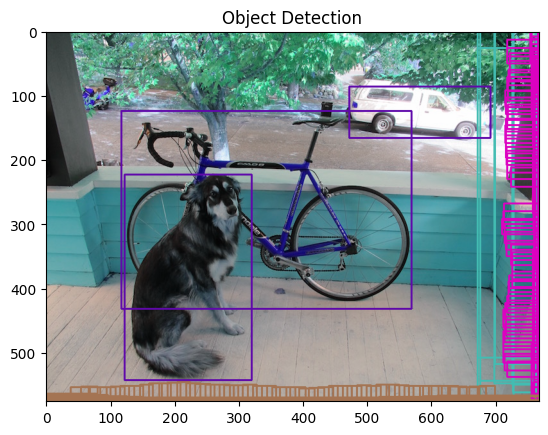

In [118]:
# Feth the indices of the boxes
for index in indices:
    
    # Retrieve box coordinates
    box = detected_boxes[index]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    
    # Draw the Bounding Box
    draw_bounding_bow(image, detected_classes[index], (round(x), round(y)), (round(x+w), round(y+h)))
    
# Save output image to disk
plt.imshow(image)
plt.title('Object Detection')
plt.show()